#Image Classification using VGG16 (Transfer Learning)

##Importing Necessary Libraries

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from imutils import paths
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score, classification_report, confusion_matrix
import cv2
import os
from google.colab import drive

In [ ]:
filterwarnings("ignore")
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/3. Transfer Learning Using VGG")

## Data Gathering

In [ ]:
train_data = sorted(list(paths.list_images("vgg_dataset/train")))
test_data = sorted(list(paths.list_images("vgg_dataset/test")))

In [ ]:
print("Train Data:", len(train_data))
print("Test Data:", len(test_data))

Train Data: 1221
Test Data: 559


In [ ]:
x_train = []
y_train = []
with tqdm(total = len(train_data)) as pbar:
    for i,j in enumerate(train_data):
        try:
            image = cv2.imread(j)
            image = cv2.resize(image, (224,224))
            x_train.append(image)
            y_train.append(train_data[i].split(sep="/")[-2])
        except:
            continue

        pbar.update(1)
            

  0%|          | 0/1221 [00:00<?, ?it/s]

In [ ]:
x_test = []
y_test = []
with tqdm(total = len(test_data)) as pbar:
    for i,j in enumerate(test_data):
        try:
            image = cv2.imread(j)
            image = cv2.resize(image, (224,224))
            x_test.append(image)
            y_test.append(test_data[i].split(sep="/")[-2])
        except:
            continue

        pbar.update(1)
            

  0%|          | 0/559 [00:00<?, ?it/s]

In [ ]:
x_train = np.array(x_train, dtype = np.int32)
x_test = np.array(x_test, dtype = np.int32)

In [ ]:
df = pd.DataFrame(y_train)
df[0].unique()

array(['buildings', 'forest', 'sea'], dtype=object)

## Label Mapping

In [ ]:
label_mapping = {"buildings": 0, "forest": 1, "sea": 2}
y_train = np.array([label_mapping[i] for i in y_train], dtype = np.int32)
y_test = np.array([label_mapping[i] for i in y_test], dtype = np.int32)

In [ ]:
print("Train Data:", len(y_train))
print("Test Data:", len(y_test))

Train Data: 1221
Test Data: 559


##Data Augmentation

In [ ]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

trainGen = trainAug.flow_from_directory(
    "vgg_dataset/train",
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=32)

Found 1221 images belonging to 3 classes.


In [ ]:
valAug = ImageDataGenerator()

testGen = valAug.flow_from_directory(
    "vgg_dataset/test",
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=32)

Found 559 images belonging to 3 classes.


## Model Building

In [ ]:
basemodel = VGG16(weights = "imagenet", input_tensor = Input(shape= (224,224,3)), include_top= False)
headmodel = basemodel.output 
headmodel = Flatten(name = "flatten") (headmodel)
headmodel = Dense(512, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(3, activation = "softmax")(headmodel)
vgg_model = Model(inputs = basemodel.input, outputs = headmodel)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for i in basemodel.layers:
    i.trainable = False

In [ ]:
vgg_model.compile(loss= "categorical_crossentropy", optimizer= Adam(1e-4), metrics= ["accuracy"])

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
H= vgg_model.fit(x = trainGen, steps_per_epoch = 32, validation_data= testGen, epochs = 10)

Epoch 1/10
32/32 [==============================] - 820s 26s/step - loss: 0.3012 - accuracy: 0.9749 - val_loss: 0.2120 - val_accuracy: 0.9839
Epoch 2/10
32/32 [==============================] - 805s 25s/step - loss: 0.3081 - accuracy: 0.9759 - val_loss: 0.2947 - val_accuracy: 0.9857
Epoch 3/10
32/32 [==============================] - 805s 25s/step - loss: 0.2342 - accuracy: 0.9860 - val_loss: 0.3596 - val_accuracy: 0.9821
Epoch 4/10
32/32 [==============================] - 800s 25s/step - loss: 0.2918 - accuracy: 0.9779 - val_loss: 0.4232 - val_accuracy: 0.9785
Epoch 5/10
32/32 [==============================] - 796s 25s/step - loss: 0.1192 - accuracy: 0.9890 - val_loss: 0.3098 - val_accuracy: 0.9875
Epoch 6/10
32/32 [==============================] - 802s 25s/step - loss: 0.3282 - accuracy: 0.9819 - val_loss: 0.3586 - val_accuracy: 0.9875
Epoch 7/10
32/32 [==============================] - 797s 26s/step - loss: 0.2559 - accuracy: 0.9779 - val_loss: 0.4981 - val_accuracy: 0.9803
Epoch 

##Model Evaluation

In [94]:
def plot_acc(H, N, plotPath=None):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("acc_output.png")

def plot_loss(H, N, plotPath=None):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
   
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig("loss_output.png")

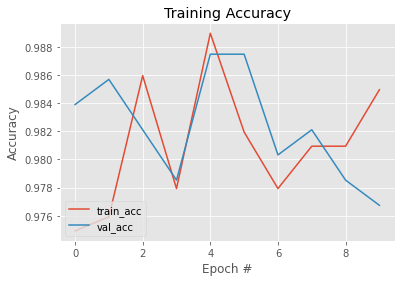

In [ ]:
plot_acc(H, 10)

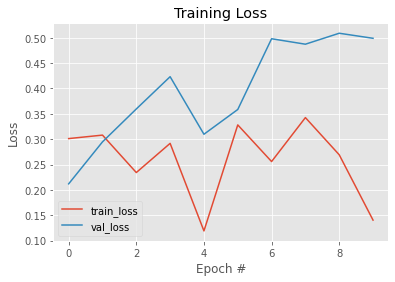

In [ ]:
plot_loss(H, 10)

In [ ]:
test_set = sorted(list(paths.list_images("test_examples")))
test_set

['test_examples/20072.jpg',
 'test_examples/20076.jpg',
 'test_examples/20077.jpg',
 'test_examples/20081.jpg',
 'test_examples/20099.jpg',
 'test_examples/20112.jpg',
 'test_examples/20114.jpg',
 'test_examples/20115.jpg',
 'test_examples/20124.jpg',
 'test_examples/20138.jpg',
 'test_examples/20140.jpg',
 'test_examples/20177.jpg',
 'test_examples/20186.jpg',
 'test_examples/20206.jpg',
 'test_examples/20268.jpg',
 'test_examples/20294.jpg',
 'test_examples/20309.jpg',
 'test_examples/20344.jpg',
 'test_examples/21209.jpg',
 'test_examples/21212.jpg',
 'test_examples/21238.jpg',
 'test_examples/21240.jpg',
 'test_examples/21250.jpg',
 'test_examples/21344.jpg',
 'test_examples/21345.jpg',
 'test_examples/21352.jpg',
 'test_examples/21358.jpg',
 'test_examples/21362.jpg']

In [75]:
for i in test_set:
    image = cv2.imread(i)
    new = np.array(cv2.resize(image, (224,224)), dtype = np.int32)
    new = new.reshape(1,224,224,3)
    result = vgg_model.predict(new)
    result = np.argmax(result)
    for j in label_mapping:
        if label_mapping[j] == result:
            cv2.putText(image, "Prediction: "+j, (20,10), cv2.FONT_HERSHEY_COMPLEX, 0.4, (255,0,0),1) 
    plt.figure(figsize = (25,25))
    plt.imshow(image)
    plt.grid(False)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [77]:
def model_evaluation(y_test, y_pred):
    print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred), "\n")
    print("Classification Report--> \n", classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot =True, fmt ="d")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

In [89]:
y_pred_prob = vgg_model.predict(x_test)

In [90]:
y_pred_prob

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.1930455e-31, 5.5403827e-36],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [8.9848695e-23, 1.9697924e-01, 8.0302078e-01],
       [8.7796393e-12, 5.5131983e-09, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [ ]:
y_pred = []
for i in y_pred_prob:
    y_pred.append(np.argmax(i))
y_pred

Cohen Kappa Score: 0.9785342626192808 

Classification Report--> 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       190
           1       0.96      1.00      0.98       182
           2       0.99      0.97      0.98       187

    accuracy                           0.99       559
   macro avg       0.99      0.99      0.99       559
weighted avg       0.99      0.99      0.99       559



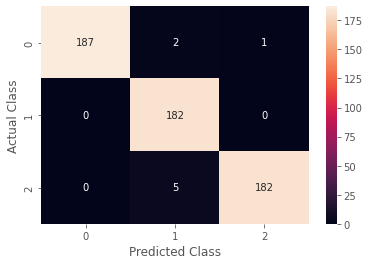

In [93]:
model_evaluation(y_test, y_pred)